In [1]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import neptune as neptune
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [29]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """
    # Initialize columns if None
    if columns is None:
        columns = []

    # Base columns to always include
    base_columns = ['sys/tags', 'sys/id', 'args/cutoff', 'args/batch_size', 'loss']
    columns.extend(base_columns)

    # Mapping for 'start' and 'end' arguments
    prefix_mapping = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }

    # Components to include in the arguments columns
    components = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']

    # Build columns for each combination of 'start/end' and components
    for position in ['start', 'end']:
        for component in components:
            prefix = prefix_mapping[position]
            column_name = f'args/{prefix}/{component}'
            columns.append(column_name)

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(
        tag=tags,
        columns=columns
    ).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(
        lambda x: x.split(',') if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table['sys/tags'].apply(lambda x: neg_tag in x)
            ]

    print(f'Table downloaded\nShape: {runs_table.shape}')
    return runs_table

def grid_results(
    runs_df,
    loss_col,
    x_col,
    y_col,
    plot_type='loss',
    hyperparam_col=None
):
    """
    Generates a heatmap based on the specified plot_type for combinations of x_col and y_col.

    Parameters:
    - runs_df (pd.DataFrame): DataFrame containing the Neptune runs data.
    - loss_col (str): Column name representing the loss values.
    - x_col (str): Column name to be used on one axis.
    - y_col (str): Column name to be used on the other axis.
    - plot_type (str): Type of plot to generate. Options are 'loss', 'count', or 'hyperparam'.
      Defaults to 'loss'.
    - hyperparam_col (str, optional): Column name of the hyperparameter or metric to aggregate and plot.
      Required if plot_type is 'hyperparam'.

    Returns:
    - None
    """

    # Ensure the necessary columns are present
    required_cols = [x_col, y_col]
    if plot_type == 'loss':
        required_cols.append(loss_col)
    elif plot_type == 'count':
        required_cols.append(loss_col)  # For counting the number of loss values
    elif plot_type == 'hyperparam':
        if not hyperparam_col:
            raise ValueError("hyperparam_col must be specified when plot_type is 'hyperparam'")
        required_cols.extend([loss_col, hyperparam_col])
    else:
        raise ValueError("Invalid plot_type. Options are 'loss', 'count', or 'hyperparam'.")

    if not all(col in runs_df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in runs_df.columns]
        raise ValueError(f"The following required columns are missing from runs_df: {missing_cols}")

    # Drop rows with NaNs in the required columns
    runs_df = runs_df.dropna(subset=required_cols)

    # Get unique sorted values of x_col and y_col
    x_values = sorted(runs_df[x_col].unique())
    y_values = sorted(runs_df[y_col].unique())

    if plot_type == 'loss':
        # Create a pivot table with the minimum loss values
        grid = runs_df.pivot_table(
            index=y_col,
            columns=x_col,
            values=loss_col,
            aggfunc='min'
        )
        fmt = ".4f"
        cmap = 'YlGn_r'
        title = f'Heatmap of Best {loss_col} Values'

    elif plot_type == 'count':
        # Create a pivot table with the count of examples
        grid = runs_df.pivot_table(
            index=y_col,
            columns=x_col,
            values=loss_col,
            aggfunc='count'
        )
        fmt = ".0f"
        cmap = 'Blues'
        title = 'Heatmap of Aggregated Example Counts'

    elif plot_type == 'hyperparam':
        # Select the rows corresponding to the best loss for each (y_col, x_col)
        idx = runs_df.groupby([y_col, x_col])[loss_col].idxmin()
        best_runs = runs_df.loc[idx]
        # Create a pivot table with the aggregated metric values
        grid = best_runs.pivot_table(
            index=y_col,
            columns=x_col,
            values=hyperparam_col,
            aggfunc='first'
        )
        fmt = ".4f"
        cmap = 'OrRd'
        title = f'Heatmap of {hyperparam_col} at Best {loss_col}'

    # Reindex the pivot table to ensure all x and y values are present
    # Corrected the reindexing step to match the swapped axes
    grid = grid.reindex(index=y_values, columns=x_values)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(grid, annot=True, fmt=fmt, cmap=cmap)
    plt.xlabel(x_col)  # x_col corresponds to columns
    plt.ylabel(y_col)  # y_col corresponds to index
    plt.title(title)
    plt.show()

### Grid results

In [34]:
tags = ["muP_MoE", "alpha_grid_3"]
negative_tags = None
all_grid_columns = ['loss_interval/100', 'args/mup_params/alpha_in', 'args/mup_params/alpha_out', 'args/learning_rate', 'args/init_scale']

loss_column = all_grid_columns[0]
x_column = all_grid_columns[3]
y_column = all_grid_columns[4]

runs_df = get_neptune_table(tags=tags, negative_tags=negative_tags, columns=all_grid_columns)


https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (187, 10)


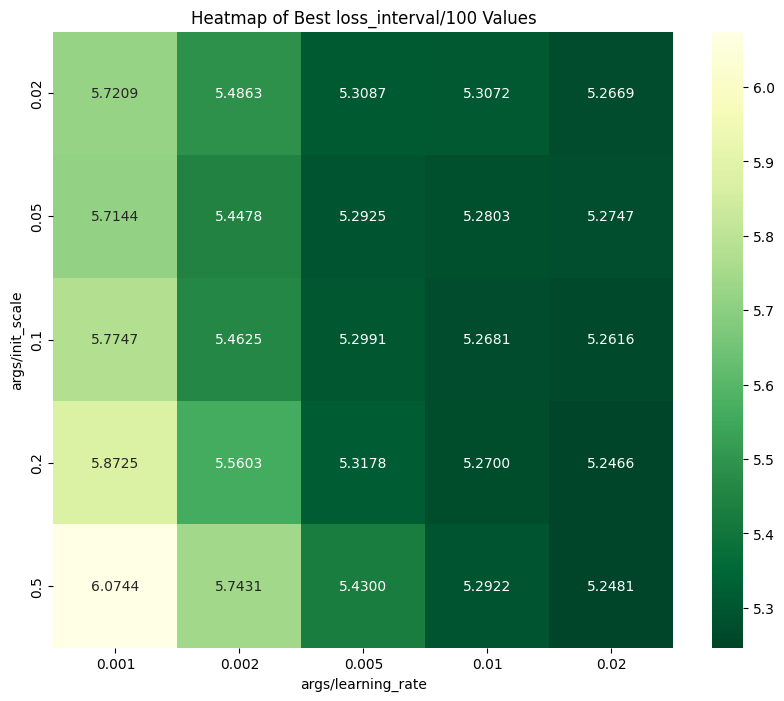

In [35]:
grid_results(runs_df, loss_col=loss_column, x_col=x_column, y_col=y_column, plot_type='loss')

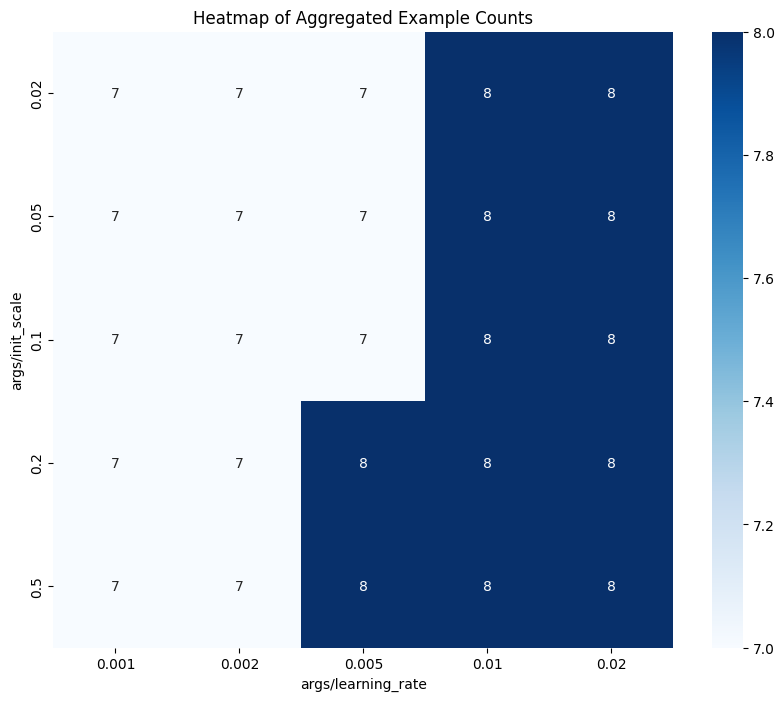

In [36]:
grid_results(runs_df, loss_col=loss_column, x_col=x_column, y_col=y_column, plot_type='count')

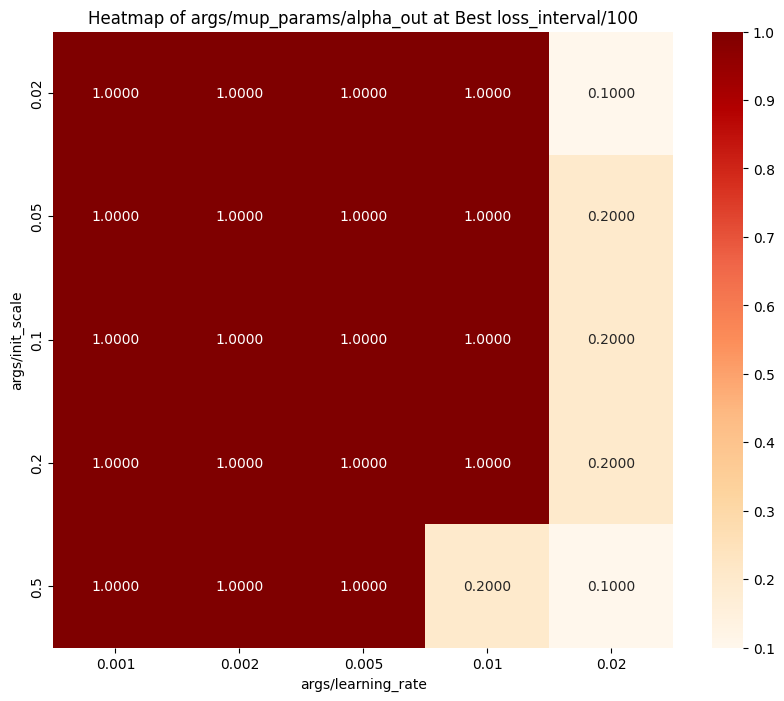

In [38]:
grid_results(runs_df, loss_col=loss_column, x_col=x_column, y_col=y_column, plot_type='hyperparam', hyperparam_col=all_grid_columns[2])